In [2]:
import sys
sys.path.append("/Users/carla/Desktop/GitHub/Projet-RNCP") 
import pandas as pd
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from src.utils.transformation import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Données réelles

In [3]:
df = pd.read_csv('database_clean.csv',parse_dates=['publishedAt','extractedAt'])
df = df.dropna(subset=['comment'])
df['comment_length'] = df['comment'].str.len()
#df.head(16)

In [4]:
df.shape

(1730, 9)

In [5]:
yt = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/data/youtube_comments_cleaned.csv')
print(yt.shape)
yt.head()

(1032225, 12)


,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2


# Données d'entrainement

In [13]:
df_tweets = pd.read_csv('../data/french_tweets.csv') # les tweets
df_yt = pd.read_csv('/Users/carla/Downloads/partial_translation_1754895688.csv') # les commentaires youtube traduits en français
df_alloc = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/data/test.csv') # les commentaires allociné
df_yt_trad = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/recovered_translations_20250907_2042.csv')

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_73832/2974595845.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_yt_trad = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/recovered_translations_20250907_2042.csv')


In [12]:
df_yt.head()

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1,Quelqu'un sait quel film c'est ?
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17,Le fait qu'ils se retiennent tout en étant aus...
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27,Vous attendez la prochaine vidéo ?
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27,Merci pour la grande vidéo. Je ne comprends pa...
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2,"C'est comme ça qu'on est en Amérique, à l'exce..."


In [14]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # rendre les résultats reproductibles

def detect_lang_safe(text):
    text = str(text).strip()
    # si le texte est trop court ou ne contient pas de lettres, on retourne "unknown"
    if not text or len(text) < 3 or text.isnumeric():
        return "unknown"
    try:
        return detect(text)
    except:
        return "unknown"

df_yt_trad['text_fr'] = df_yt_trad['text_fr'].fillna(" ").astype(str)
df_yt_trad['lang'] = df_yt_trad['text_fr'].apply(detect_lang_safe)

In [15]:
df_yt_trad = df_yt_trad[df_yt_trad['lang'] == "fr"].reset_index(drop=True)

In [16]:
import pickle
with open("df_yt_trad.csv", "w") as f:
    df_yt_trad.to_csv(f)

In [5]:
df_yt_trad.head(20)

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr,lang
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1,Quelqu'un sait de quel film c'est?,fr
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17,Le fait qu'ils se retiennent tout en étant le ...,fr
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27,La prochaine vidéo en attente sera?,fr
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video. I don't understan...,Neutral,0,1,2024-09-18 12:04:12,US,27,Merci pour la super vidéo. Je ne comprends pas...,fr
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people. This is how i...,Positive,3,1,2025-01-10 19:39:03,US,2,Bonne personne aidant les bonnes personnes. C'...,fr
5,UgzJ-2rV0-YNPyMj0u14AaABAg,X4wNLFrv9Co,Which one will you choose to use the cola keyc...,@JasmineHatchel-c3c,UCHvnyO2K7-1oXXdWQh0510g,Number two because it looks the best with it,Positive,0,0,2025-01-10 06:00:19,US,28,Numéro deux car il a l'air le meilleur avec,fr
6,UgwuFh4s9cHu3dHrPqJ4AaABAg,sKniMxl9zwo,Trump’s Reaction During ‘Abuse of Power’ Says ...,@StaceyBrown-h6o,UCzTaRiUaLcaLD9I0l2tCBCA,Thank God we don’t have to listen to his drive...,Positive,0,0,2025-01-14 01:24:48,IE,25,"Dieu merci, nous n'avons plus à écouter son ra...",fr
7,UgwzYX76p4RK8AHVcYN4AaABAg,yUImrnDqGUk,Thank god this angel found this beautiful dog ...,@cassiegerst6123,UC-QvE5-ZberkWmSYDXLvfQA,Very similar thing happened to me! We lived ne...,Positive,0,0,2025-01-14 03:54:19,AU,15,Une chose très similaire m'est arrivée! Nous v...,fr
8,UgzW7h-gmtmgIFFClLJ4AaABAg,5VPxcrvVkBc,He betrayed his own friend - Enjoying a cup of...,@josh_playz2709,UCflV1g1fmgs5i2QZwiaHT8g,im about to cry😢,Negative,0,0,2025-01-13 09:55:03,IE,20,Je suis sur le point de pleurer😢,fr
9,UgyqrXh3SW_NpUqyc_Z4AaABAg,eWRfhZUzrAc,Python for Beginners – Full Course [Programmin...,@t.a-8469,UCELGbox9iW4QjIJF37s9E-Q,This is really valuable information and I appr...,Neutral,1,0,2024-02-01 07:16:35,US,27,Ce sont des informations vraiment précieuses e...,fr


In [4]:

# df_yt_fr = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/data/youtube_comments_cleaned.csv')
# df_yt_fr.groupby('VideoTitle')['CommentID'].count().reset_index().sort_values(by='CommentID', ascending=False)


In [9]:
# df_yt_fr[df_yt_fr['VideoID'] == 'Lzccd-ol1Ks'].head(10)
# # BTLcjQUued8Cc4qYw

In [62]:
import pandas as pd
trad = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/translated_dataset_20250905_2324.csv')
print(trad.shape)
trad.head()

(1002, 13)


,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1.0,Quelqu'un sait de quel film c'est?
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17.0,Le fait qu'ils se retiennent tout en étant le ...
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27.0,La prochaine vidéo en attente sera?
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27.0,Merci pour la super vidéo.\n\nJe ne comprends ...
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2.0,Bonne personne aidant les bonnes personnes.\nC...


# EDA

In [8]:
df_tweets.shape, df_yt.shape, df_alloc.shape

((1526724, 2), (25000, 13), (20000, 4))

In [14]:
df_tweets.info(), df_yt.info(), df_alloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526724 entries, 0 to 1526723
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1526724 non-null  int64 
 1   text    1526724 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentID        25000 non-null  object
 1   VideoID          25000 non-null  object
 2   VideoTitle       25000 non-null  object
 3   AuthorName       24982 non-null  object
 4   AuthorChannelID  25000 non-null  object
 5   CommentText      25000 non-null  object
 6   Sentiment        25000 non-null  object
 7   Likes            25000 non-null  int64 
 8   Replies          25000 non-null  int64 
 9   PublishedAt      25000 non-null  object
 10  CountryCode      25000 non-null

(None, None, None)

In [15]:
# le nombre de commentaires (id) par vidéo (videoid) en ordor décroissant du nombre de commentaires
df_yt.groupby('VideoID')['CommentID'].count().reset_index().sort_values(by='CommentID', ascending=False)


,VideoID,CommentID
2159,TloMiwQv1x4,34
1603,Lzccd-ol1Ks,34
58,-hV6aeyPHPA,32
152,1DsMZuJm5Sg,31
121,0gASceRnltg,31
...,...,...
1500,KKgN_w71x3E,1
2907,dQlw1Cdd3pw,1
1486,K7ghUiXLef8,1
2913,dYrniSWkLAY,1


/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


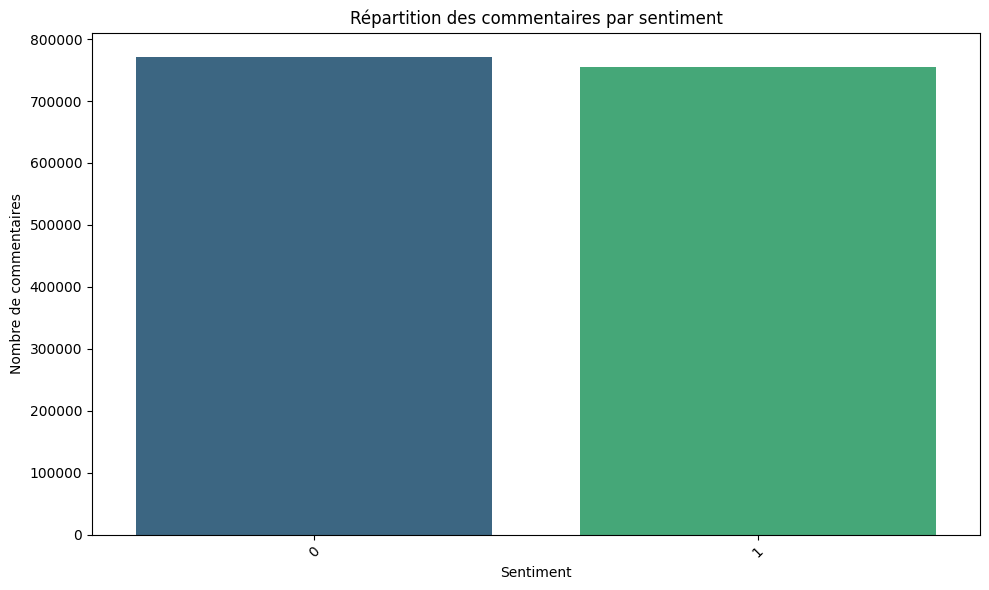

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


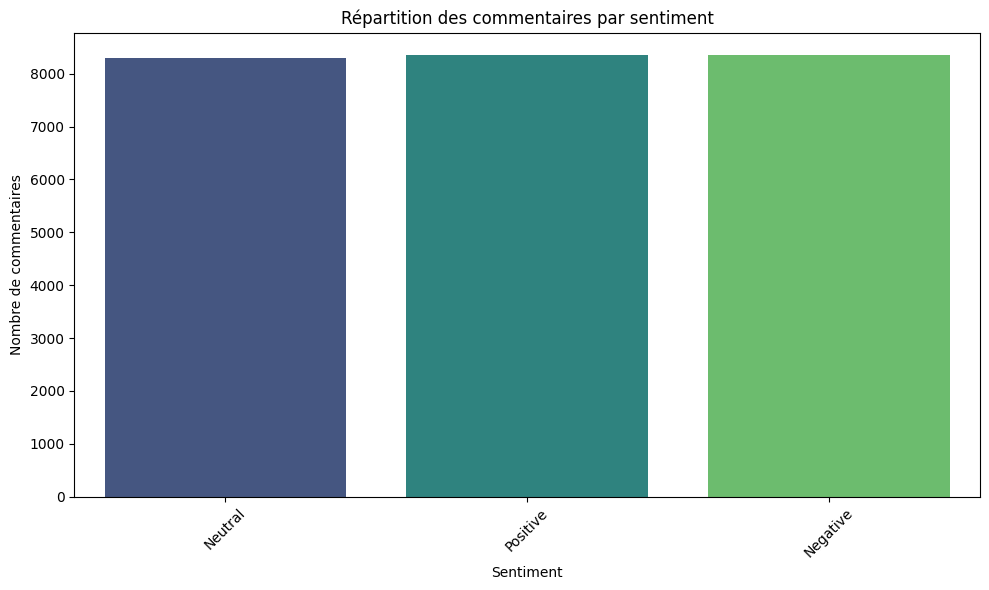

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


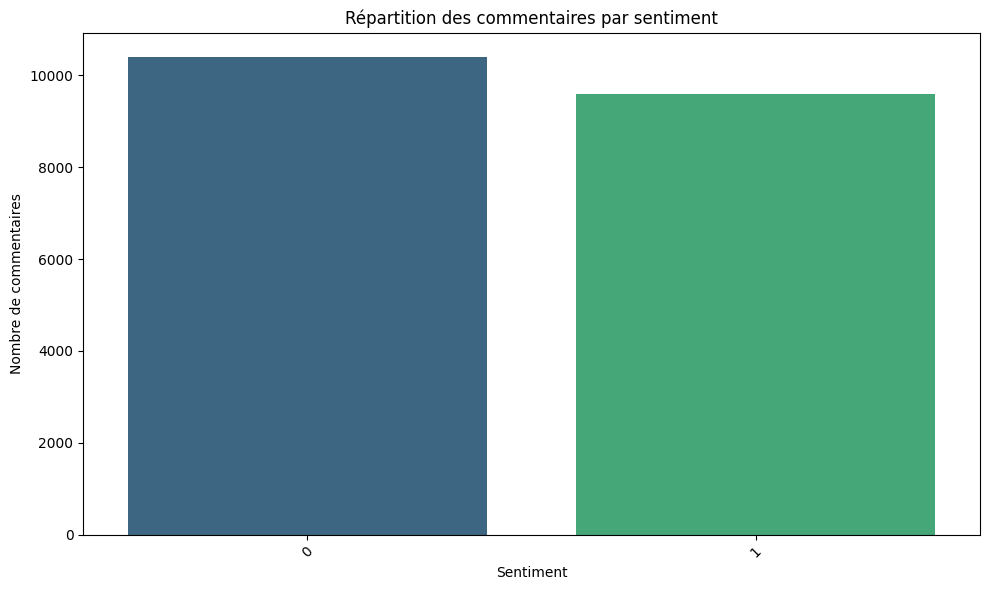

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


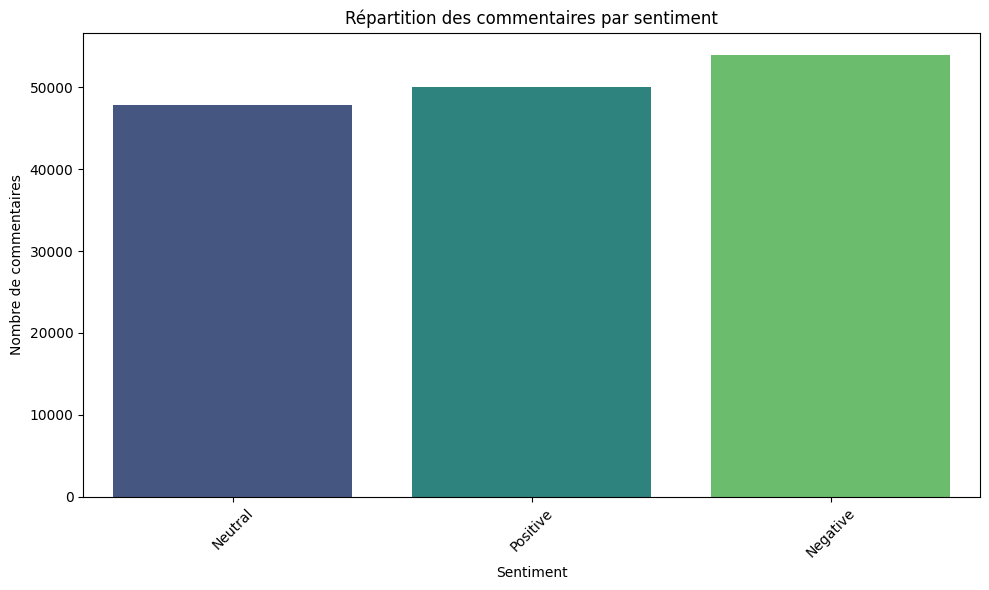

In [26]:
# graphique répartition des commentaires par sentiment
def plot_sentiment_distribution(df : pd.DataFrame, x :str) :
    """
    Affiche la répartition des sentiments dans le DataFrame.
    
    :param df: DataFrame contenant les sentiments
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=x, palette='viridis')
    plt.title('Répartition des commentaires par sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Nombre de commentaires')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_sentiment_distribution(df_tweets, 'label')

plot_sentiment_distribution(df_yt, 'Sentiment')

plot_sentiment_distribution(df_alloc, 'polarity')

# plot_sentiment_distribution(trad, 'Sentiment')

plot_sentiment_distribution(df_yt_trad, 'Sentiment')

In [12]:
from langdetect import detect
# filtre de data set sur les commentaires en anglais
def safe_detect(text):
    try:
        return detect(text.strip()) if isinstance(text, str) and text.strip() else None
    except Exception as e:
        return None  # Return None if detection fails


# ANALYSE DE SIMILARITÉ

In [31]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_tweets['text']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

def get_vocab(texts):
        """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
        vocab = set()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            vocab.update(words)
        return vocab

dataset_vocab = get_vocab(df_tweets['text'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_tweets['text']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_tweets['text'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.0627231978668098,
 'length_effect_size': 0.0015042652996436574,
 'length_similar': True,
 'jaccard': 0.015,
 'coverage_to_yt': 0.015,
 'coverage_from_yt': 0.849,
 'tfidf_cosine': 0.676,
 'composite_score': 0.439,
 'dataset_vocab_size': 253124,
 'youtube_vocab_size': 4552,
 'common_words': 3864,
 'dataset_avg_length': 14.1,
 'youtube_avg_length': 17.8}

In [32]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_alloc['review']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

def get_vocab(texts):
        """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
        vocab = set()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            vocab.update(words)
        return vocab

dataset_vocab = get_vocab(df_alloc['review'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_alloc['review']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_alloc['review'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.0,
 'length_effect_size': 0.38080508517052697,
 'length_similar': False,
 'jaccard': 0.061,
 'coverage_to_yt': 0.062,
 'coverage_from_yt': 0.78,
 'tfidf_cosine': 0.639,
 'composite_score': 0.429,
 'dataset_vocab_size': 57023,
 'youtube_vocab_size': 4552,
 'common_words': 3552,
 'dataset_avg_length': 92.5,
 'youtube_avg_length': 17.8}

In [33]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_yt['text_fr']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

def get_vocab(texts):
        """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
        vocab = set()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            vocab.update(words)
        return vocab

dataset_vocab = get_vocab(df_yt['text_fr'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_yt['text_fr']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_yt['text_fr'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.27747154618981473,
 'length_effect_size': 0.0066388252969118945,
 'length_similar': True,
 'jaccard': 0.085,
 'coverage_to_yt': 0.089,
 'coverage_from_yt': 0.651,
 'tfidf_cosine': 0.746,
 'composite_score': 0.416,
 'dataset_vocab_size': 33469,
 'youtube_vocab_size': 4552,
 'common_words': 2963,
 'dataset_avg_length': 18.4,
 'youtube_avg_length': 17.8}

In [23]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_yt['text_fr']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

# def get_vocab(texts):
#         """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
#         vocab = set()
#         for text in texts:
#             words = re.findall(r'\b\w+\b', text.lower())
#             vocab.update(words)
#         return vocab

def get_vocab(texts):
    """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
    vocab = set()
    for text in texts:
        if not isinstance(text, str):  # Skip non-string values
            continue
        words = re.findall(r'\b\w+\b', text.lower())
        vocab.update(words)
    return vocab

dataset_vocab = get_vocab(trad['text_fr'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_yt['text_fr']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_yt['text_fr'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.27747154618981473,
 'length_effect_size': 0.0066388252969118945,
 'length_similar': True,
 'jaccard': 0.173,
 'coverage_to_yt': 0.283,
 'coverage_from_yt': 0.309,
 'tfidf_cosine': 0.746,
 'composite_score': 0.357,
 'dataset_vocab_size': 4981,
 'youtube_vocab_size': 4552,
 'common_words': 1408,
 'dataset_avg_length': 18.4,
 'youtube_avg_length': 17.8}

In [34]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_yt_trad['text_fr']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

# def get_vocab(texts):
#         """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
#         vocab = set()
#         for text in texts:
#             words = re.findall(r'\b\w+\b', text.lower())
#             vocab.update(words)
#         return vocab

def get_vocab(texts):
    """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
    vocab = set()
    for text in texts:
        if not isinstance(text, str):  # Skip non-string values
            continue
        words = re.findall(r'\b\w+\b', text.lower())
        vocab.update(words)
    return vocab

dataset_vocab = get_vocab(df_yt_trad['text_fr'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_yt_trad['text_fr']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_yt_trad['text_fr'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 8.89185936102673e-29,
 'length_effect_size': 0.028385610266154326,
 'length_similar': True,
 'jaccard': 0.044,
 'coverage_to_yt': 0.044,
 'coverage_from_yt': 0.766,
 'tfidf_cosine': 0.74,
 'composite_score': 0.436,
 'dataset_vocab_size': 78394,
 'youtube_vocab_size': 4552,
 'common_words': 3488,
 'dataset_avg_length': 22.9,
 'youtube_avg_length': 17.8}

# classification

In [10]:
# df_fr = main_transformation(df_yt, 'text_fr','/Users/carla/Desktop/GitHub/Projet-RNCP/extra_expressions.txt')
# df_fr.head()

In [63]:
# print(f"la forme avant {trad.shape}")
# index = []
# for i in range(len(trad)):
#     # print(type(trad['text_fr'].iloc[i]))
#     if not isinstance(trad['text_fr'].iloc[i], str):
#         # trad = pd.DataFrame(trad.drop(trad.index[i], axis=0, inplace=True))
#         index.append(i)
#         # print(type(trad))
# trad = pd.DataFrame(trad.drop(labels=index, axis=0))
# print(f"la forme après {trad.shape}")


la forme avant (1002, 13)
la forme après (987, 13)


In [6]:
df_yt_trad = pd.read_csv("/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/df_yt_trad.csv")

In [7]:
df_yt_trad.shape

(151884, 15)

In [8]:
df_yt_trad['text_fr'] = df_yt_trad['text_fr'].fillna('').astype(str)

In [9]:
# precpocessing 
from src.utils.transformation import preprocessing
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer


path = '/Users/carla/Desktop/GitHub/Projet-RNCP/extra_expressions.txt'
df_yt_trad['comment_clean_lem'] = df_yt_trad['text_fr'].astype(str).apply(lambda x: preprocessing(x, join=True, path=path))
df_yt_trad['tokens_clean_lem'] = df_yt_trad['text_fr'].apply(lambda x: preprocessing(x, join=False, path=path))

In [10]:
# vectorisation 
## w2vec
# Exemple de corpus
sentences = df_yt_trad['comment_clean_lem'].dropna().tolist()
tokenized_sentences = [simple_preprocess(sent) for sent in sentences if sent.strip() != '']



In [11]:
model_w2v = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

def get_sentence_vector(sentence, model):
    if pd.isna(sentence):  # Gestion des valeurs NaN
        return np.zeros(model.vector_size)
    words = simple_preprocess(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # moyenne des vecteurs
    else:
        return np.zeros(model.vector_size)
    


In [12]:
df_yt_trad['w2vec_vector'] = df_yt_trad['comment_clean_lem'].apply(lambda x: get_sentence_vector(x, model_w2v))

## tfidf
# Exemple de corpus
corpus = df_yt_trad['text_fr'].tolist()  # Assurez-vous que les commentaires ne sont pas vides .dropna()



In [13]:
# Initialisation du vecteur TF-IDF
vectorizer = TfidfVectorizer()


In [14]:
# Entraînement du modèle TF-IDF
tfidf_matrix = vectorizer.fit_transform(corpus)


In [15]:
# ajouter une colonne avec les vecteurs TF-IDF
df_yt_trad['tfidf_vector'] = list(tfidf_matrix.toarray())

In [4]:
# # vectorisation du texte
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess

# # text_fr = pd.read_csv("../data/youtube_comments_fr_translated_marian.csv")

# # Exemple de corpus
# sentences = df_train2['comment_clean_lem'].dropna().tolist()  # Assurez-vous que les commentaires ne sont pas vides

# # Prétraitement (tokenisation simple)
# tokenized_sentences = [simple_preprocess(sent) for sent in sentences]

# # Entraînement Word2Vec (skip-gram)
# model_w2v = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

# # # Exemple : obtenir le vecteur pour le mot 'apprendre'
# # # vector_apprendre = model_w2v.wv['apprendre']
# # # print(f"Vector for 'apprendre' (Word2Vec):\n{vector_apprendre}")

# # # Trouver mots similaires
# # # similaires = model_w2v.wv.most_similar('apprendre', topn=3)
# # # print("Mots les plus similaires à 'apprendre' :", similaires)


In [11]:
# import inspect
# import sys
# import importlib

# module_name = "src.utils.transformation"

# # Remove the module from the cache
# if module_name in sys.modules:
#     del sys.modules[module_name]

# # Import and reload the module
# from src.utils.transformation import * 

# inspect.signature(main_transformation).parameters

In [255]:
# def get_sentence_vector(sentence, model):
#     words = simple_preprocess(sentence)
#     word_vectors = [model.wv[word] for word in words if word in model.wv]
#     if len(word_vectors) > 0:
#         return np.mean(word_vectors, axis=0)  # moyenne des vecteurs
#     else:
#         return np.zeros(model.vector_size)
    
# df_fr['w2vec_vector'] = df_fr['comment_clean_lem'].apply(lambda x: get_sentence_vector(x, model_w2v))

In [6]:
# # vectorisation tfidf
# from sklearn.feature_extraction.text import TfidfVectorizer
# # Exemple de corpus
# corpus = df_train2['text_fr'].dropna().tolist()  # Assurez-vous que les commentaires ne sont pas vides
# # Initialisation du vecteur TF-IDF
# vectorizer = TfidfVectorizer()
# # Entraînement du modèle TF-IDF
# tfidf_matrix = vectorizer.fit_transform(corpus)
# # ajouter une colonne avec les vecteurs TF-IDF
# df_fr['tfidf_vector'] = list(tfidf_matrix.toarray())

# # def get_tfidf_vector(df, text='comment_clean_lem'):
# #     """
# #     Obtenir le vecteur TF-IDF d'une phrase
# #     """
# #     vectorizer = TfidfVectorizer()
# #     corpus = df[text].dropna().tolist()
# #     tfidf_matrix = vectorizer.fit_transform(corpus)
# #     df['tfidf_vector'] = list(tfidf_matrix.toarray())
# #     return df


In [11]:
# # ajouter une colonne avec le texte vectoriser
# df_fr['vector'] = df_fr['comment_clean_lem'].apply(lambda x: model_w2v.wv[simple_preprocess(x)] if pd.notnull(x) else None)
# df_fr.head(10)

In [16]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_yt_trad['Sentiment'].values)
# label_encoder.classes_



In [18]:
# Conversion en matrices NumPy 2D
# x_knn = np.vstack(df_yt_trad['w2vec_vector'].values)
# x = np.vstack(df_yt_trad['tfidf_vector'].values)
x = tfidf_matrix
# -- convertit w2v en matrice dense 2D (doit avoir le même nombre de lignes)
x_knn = np.vstack(df_yt_trad['w2vec_vector'].values).astype(np.float32)
print("X_w2v shape:", x_knn.shape)
print("X_ shape:", x.shape)


X_w2v shape: (151884, 100)
X_ shape: (151884, 78252)


In [38]:
# Séparation des données en ensembles d'entraînement et de test
x_knn = np.array(df_yt_trad['w2vec_vector'].tolist())
x = np.array(df_yt_trad['tfidf_vector'].tolist())
# w = np.array(df_yt_trad['text_fr'].tolist())

: 

In [38]:
w = np.array(df_yt_trad['text_fr'].tolist())

In [39]:
x_train, x_test, x_knn_train, x_knn_test, w_train, w_test, y_train, y_test  = train_test_split(x, x_knn,w, y, test_size=0.2, random_state=42) #, w_train, w_test  w,
# print(f"Train set size: {len(x_train)}, Test set size: {len(x_test)}")
print(f"les shapes des données d'entraînement et de test: {x_train.shape}, {x_test.shape}")
print(f"les shapes des labels d'entraînement et de test: {y_train.shape}, {y_test.shape}")
print(f"les shapes des texts d'entraînement et de test: {w_train.shape}, {w_test.shape}")
print(f"les shapes des vecteurs d'entraînement et de test: {x_knn_train.shape}, {x_knn_test.shape}")
print(label_encoder.classes_)


les shapes des données d'entraînement et de test: (121507, 78252), (30377, 78252)
les shapes des labels d'entraînement et de test: (121507,), (30377,)
les shapes des texts d'entraînement et de test: (121507,), (30377,)
les shapes des vecteurs d'entraînement et de test: (121507, 100), (30377, 100)
['Negative' 'Neutral' 'Positive']


In [26]:
accuracy =[]
fscores = []

print("Entraînement des modèles de classification...")

# Entraînement du modèle Random Forest
rf= RandomForestClassifier(n_estimators=100, random_state=42)
# entraienellement du modèle arbre de décision
dt = DecisionTreeClassifier(random_state=42)
# entraienellement du modèle SVM
# svm = SVC(kernel='linear', random_state=42)
# entraienellement du modèle régression logistique
lr = LogisticRegression(max_iter=1000, random_state=42)
# entraienellement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
# entraienellement du modèle Naive Bayes
nb = MultinomialNB()

print("Entraînement du modèle Random Forest...")
rf.fit(x_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_rf = rf.predict(x_test)
# Évaluation du modèle
from sklearn.metrics import classification_report, accuracy_score
print(f"Classification Report\n:{classification_report(y_test, y_pred_rf)}")
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", {acc_rf})
accuracy.append(acc_rf)
fscore_rf = f1_score(y_test, y_pred_rf, average='weighted')
fscores.append(fscore_rf)
print("F1 Score:", fscore_rf)


print("Entraînement du modèle Arbre de Décision...")
dt.fit(x_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_dt = dt.predict(x_test)
# Évaluation du modèle
print(f"Classification Report\n:{classification_report(y_test, y_pred_dt)}")
acc_dt = accuracy_score(y_test, y_pred_dt)
accuracy.append(acc_dt)
print("Accuracy:", acc_dt)
fscore_dt = f1_score(y_test, y_pred_dt, average='weighted')
fscores.append(fscore_dt)
print("F1 Score:", fscore_dt)

# print("Entraînement du modèle SVM...")
# svm.fit(x_train, y_train)
# # Prédictions sur l'ensemble de test
# y_pred_svm = svm.predict(x_test)
# # Évaluation du modèle
# print(f"Classification Report\n:{classification_report(y_test, y_pred_svm)}")
# acc_svm = accuracy_score(y_test, y_pred_svm)
# accuracy.append(acc_svm)
# print("Accuracy:", acc_svm)
# fscore_svm = f1_score(y_test, y_pred_svm, average='weighted')
# fscores.append(fscore_svm)
# print("F1 Score:", fscore_svm)

print("Entraînement du modèle Regression logistique...")
lr.fit(x_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_lr = lr.predict(x_test)
# Évaluation du modèle
print(f"Classification Report\n:{classification_report(y_test, y_pred_lr)}")
acc_lr = accuracy_score(y_test, y_pred_lr)
accuracy.append(acc_lr)
print("Accuracy:", acc_lr)
fscore_lr = f1_score(y_test, y_pred_lr, average='weighted')
fscores.append(fscore_lr)
print("F1 Score:", fscore_lr)

print("Entraînement du modèle KNN...")
knn.fit(x_knn_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_knn = knn.predict(x_knn_test)
# Évaluation du modèle
print(f"Classification Report\n:{classification_report(y_test, y_pred_knn)}")
acc_knn = accuracy_score(y_test, y_pred_knn)
accuracy.append(acc_knn)
print("Accuracy:", acc_knn)
fscore_knn = f1_score(y_test, y_pred_knn, average='weighted')
fscores.append(fscore_knn)
print("F1 Score:", fscore_knn)


Entraînement des modèles de classification...
Entraînement du modèle Random Forest...
Classification Report
:              precision    recall  f1-score   support

           0       0.58      0.72      0.65     10850
           1       0.56      0.52      0.54      9462
           2       0.75      0.61      0.67     10065

    accuracy                           0.62     30377
   macro avg       0.63      0.62      0.62     30377
weighted avg       0.63      0.62      0.62     30377

Accuracy: {0.6215887019784706}
F1 Score: 0.621113509826282
Entraînement du modèle Arbre de Décision...
Classification Report
:              precision    recall  f1-score   support

           0       0.52      0.52      0.52     10850
           1       0.45      0.47      0.46      9462
           2       0.58      0.56      0.57     10065

    accuracy                           0.52     30377
   macro avg       0.52      0.52      0.52     30377
weighted avg       0.52      0.52      0.52     30377

Acc

In [ ]:
# text raw
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
predictions = []
for text in w_test:
    vs = tb(text).sentiment[0]
    if (vs > 0):
        predictions.append(2)#2
    elif (vs < 0):
        predictions.append(0)#0
    else:
        predictions.append(1)#1
y_pred_txtb = np.array(predictions)
# label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Adaptez selon vos labels
# if isinstance(y_test[0], (int, np.integer)):
#     y_pred_textb_mapped = [label_mapping.get(pred, 1) for pred in y_pred_txtb]
#     y_pred_txtb = np.array(y_pred_textb_mapped)

print(f"Classification Report:\n{classification_report(y_test, y_pred_txtb)}")
acc_textb = accuracy_score(y_test, y_pred_txtb)
accuracy.append(acc_textb)
print(f"Accuracy: {acc_textb:.4f}")
fscore_textb = f1_score(y_test, y_pred_txtb, average='weighted')
fscores.append(fscore_textb)
print(f"F1 Score: {fscore_textb:.4f}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.32      0.41     10850
           1       0.45      0.39      0.42      9462
           2       0.45      0.73      0.56     10065

    accuracy                           0.48     30377
   macro avg       0.50      0.48      0.46     30377
weighted avg       0.50      0.48      0.46     30377

Accuracy: 0.4773
F1 Score: 0.4625



In [ ]:
from textblob import TextBlob
def get_sentiment_textblob(text):
    """Analyse de sentiment avec TextBlob"""
    try:
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity
        
        if polarity > 0.1:
            return 2 # positive
        elif polarity < -0.1:
            return 0 # negative
        else:
            return 1 # neutral
    except:
        return 1 # neutral in case of error

predictions_textblob = []
for text in w_test:
    sentiment = get_sentiment_textblob(text)
    predictions_textblob.append(sentiment)

y_pred_textblob = np.array(predictions_textblob)
# if isinstance(y_test[0], (int, np.integer)):
#     y_pred_textblob_mapped = [label_mapping.get(pred, 1) for pred in y_pred_textblob]
#     y_pred_textblob = np.array(y_pred_textblob_mapped)

print("RÉSULTATS TEXTBLOB:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_textblob)}")
acc_textblob = accuracy_score(y_test, y_pred_textblob)
accuracy.append(acc_textblob)
print(f"Accuracy: {acc_textblob:.4f}")
fscore_textblob = f1_score(y_test, y_pred_textblob, average='weighted')
fscores.append(fscore_textblob)
print(f"F1 Score: {fscore_textblob:.4f}\n")


RÉSULTATS TEXTBLOB:
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.05      0.09     10850
           1       0.32      0.90      0.47      9462
           2       0.50      0.15      0.23     10065

    accuracy                           0.35     30377
   macro avg       0.46      0.37      0.26     30377
weighted avg       0.46      0.35      0.25     30377

Accuracy: 0.3464
F1 Score: 0.2547



In [63]:
# readSentiment = SentimentIntensityAnalyzer()
# predictions = []      
# for text in w_train:
#     # print(text)
#     # Calcul du score composé VADER
#     scores = readSentiment.polarity_scores(str(text))
#     compound_score = scores['compound']
    
#     # Classification basée sur les seuils
#     if compound_score >= 0.05:  # seuil positif
#         predictions.append('positive')  # ou 1 selon votre encodage
#     elif compound_score <= -0.05:  # seuil négatif
#         predictions.append('negative')  # ou 0 selon votre encodage
#     else:
#         predictions.append('neutral')   # ou 2 selon votre encodage
# y_pred_vader = np.array(predictions)
# label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Adaptez selon vos labels
# if isinstance(y_test[0], (int, np.integer)):
#     y_pred_vader_mapped = [label_mapping.get(pred, 1) for pred in y_pred_vader]
#     y_pred_vader = np.array(y_pred_vader_mapped)

# print(f"Classification Report:\n{classification_report(y_test, y_pred_vader)}")
# acc_vader = accuracy_score(y_test, y_pred_vader)
# accuracy.append(acc_vader)
# print(f"Accuracy: {acc_vader:.4f}")
# fscore_vader = f1_score(y_test, y_pred_vader, average='weighted')
# fscores.append(fscore_vader)
# print(f"F1 Score: {fscore_vader:.4f}\n")

# # nb.fit(x_train, y_train)
# # # Prédictions sur l'ensemble de test
# # y_pred_nb = nb.predict(x_test)
# # # Évaluation du modèle
# # print(f"Classification Report:{classification_report(y_test, y_pred_nb)}")
# # acc_nb = accuracy_score(y_test, y_pred_nb)
# # accuracy.append(acc_nb)
# # print("Accuracy:", acc_nb)

# # comparaison des modèles
# models = {
#     "Random Forest": rf,
#     "Decision Tree": dt,
#     "SVM": svm,
#     "Logistic Regression": lr,
#     "KNN": knn,
#     "vader": readSentiment
# }

In [13]:
# from transformers import pipeline

# def get_sentiment(text : str, classifier, all=False ) -> str:
#     res = classifier(text)[0]
#     max_result = max(res, key=lambda x: x['score'])
#     if all == True :
#         return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
#     else:
#         return max_result['label']


# distilled_student_sentiment_classifier = pipeline(
#     model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
#     return_all_scores=True, max_length=512, 
# )
# predictions_distilbert = []
# for text in w_test:
#     sentiment = get_sentiment(text, classifier=distilled_student_sentiment_classifier)
#     if sentiment == 'neutral':
#         predictions_distilbert.append(1) # neutral
#     elif sentiment == 'negative':
#         predictions_distilbert.append(0) # negative
#     elif sentiment == 'positive':
#         predictions_distilbert.append(2) # positive

# y_pred_distilbert = np.array(predictions_distilbert)

# print(y_pred_distilbert)
# print("RÉSULTATS distilbert:")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_distilbert)}")
# acc_distilbert = accuracy_score(y_test, y_pred_distilbert)
# accuracy.append(acc_distilbert)
# print(f"Accuracy: {acc_distilbert:.4f}")
# fscore_distilbert = f1_score(y_test, y_pred_distilbert, average='weighted')
# fscores.append(fscore_distilbert)
# print(f"F1 Score: {fscore_distilbert:.4f}\n")



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `trun

[0 0 2 ... 2 2 2]
RÉSULTATS distilbert:
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.67      0.57      1707
           1       0.34      0.06      0.09      1684
           2       0.48      0.70      0.57      1609

    accuracy                           0.47      5000
   macro avg       0.43      0.48      0.41      5000
weighted avg       0.43      0.47      0.41      5000

Accuracy: 0.4746
F1 Score: 0.4080



In [14]:
# classifier = pipeline(
#     "sentiment-analysis",
#     model="cardiffnlp/twitter-roberta-base-sentiment-latest"
# )

# predictions_roberta = []
# for text in w_test:
#     res = classifier(text)[0]
#     sentiment =res.get('label')
#     if sentiment == "positif":
#         predictions_roberta.append(2) # positive
#     elif sentiment == "negatif":
#         predictions_roberta.append(0)
#     elif sentiment == "neutral":
#         predictions_roberta.append(1)
#     else:
#         predictions_roberta.append(1)

# y_pred_roberta = np.array(predictions_roberta)

# print(y_pred_roberta)
# print("RÉSULTATS roberta:")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_roberta)}")
# acc_roberta = accuracy_score(y_test, y_pred_roberta)
# accuracy.append(acc_roberta)
# print(f"Accuracy: {acc_roberta:.4f}")
# fscore_roberta = f1_score(y_test, y_pred_roberta, average='weighted')
# fscores.append(fscore_roberta)
# print(f"F1 Score: {fscore_roberta:.4f}\n")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


[1 1 1 ... 1 1 1]
RÉSULTATS roberta:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1707
           1       0.34      1.00      0.50      1684
           2       0.00      0.00      0.00      1609

    accuracy                           0.34      5000
   macro avg       0.11      0.33      0.17      5000
weighted avg       0.11      0.34      0.17      5000

Accuracy: 0.3368
F1 Score: 0.1697



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [30]:
# analyzer = SentimentIntensityAnalyzer(lexicon_file="/Users/carla/Desktop/GitHub/Projet-RNCP/data/vader_lexicon.txt")

In [31]:

# def getSentiment(phrase):
#     s = analyzer.polarity_scores(phrase)
#     if s['compound'] <= -0.05:
#         sentiment = 0
#     elif s['compound'] >= 0.05:
#         sentiment = 1
#     else:
#         sentiment = 2
#     return sentiment

# predictions_vader = []
# for text in w_test:
#     sentiment =getSentiment(text)
#     if sentiment == "positif":
#         predictions_vader.append(2) # positive
#     elif sentiment == "negatif":
#         predictions_vader.append(0)
#     elif sentiment == "neutral":
#         predictions_vader.append(1)
#     else:
#         predictions_vader.append(1)

# y_pred_vader = np.array(predictions_vader)

# print(y_pred_vader)
# print("RÉSULTATS vader:")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_vader)}")
# acc_vader = accuracy_score(y_test, y_pred_vader)
# accuracy.append(acc_vader)
# print(f"Accuracy: {acc_vader:.4f}")
# fscore_vader = f1_score(y_test, y_pred_vader, average='weighted')
# fscores.append(fscore_vader)
# print(f"F1 Score: {fscore_vader:.4f}\n")

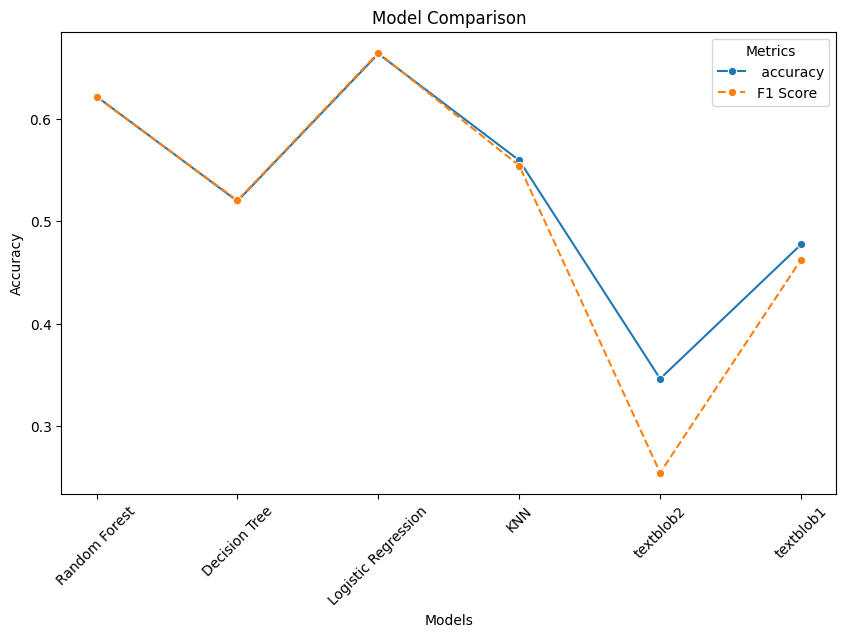

In [45]:
# Visualisation des résultats
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Random Forest": rf,
    "Decision Tree": dt,
    # "SVM": svm,
    "Logistic Regression": lr,
    "KNN": knn,
    "textblob2": TextBlob,
    "textblob1": Blobber
}

# Visualisation des résultats
plt.figure(figsize=(10, 6))
# sns.barplot(x=list(models.keys()), y=accuracy)
sns.lineplot(x=list(models.keys()), y=accuracy, marker='o',label=' accuracy')
sns.lineplot(x=list(models.keys()), y=fscores, marker='o', linestyle='--', label='F1 Score')
plt.legend(title='Metrics')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.show()

In [28]:
# le meilleur model
best_model_index = np.argmax(accuracy)
best_model_name = list(models.keys())[best_model_index]
best_model_accuracy = accuracy[best_model_index]
print(f"Best model: {best_model_name} with accuracy: {best_model_accuracy:.4f}")
# le meilleur model
best_fscore_index = np.argmax(fscores)
best_fscore_name = list(models.keys())[best_fscore_index]
best_fscore = fscores[best_fscore_index]
print(f"Best model by F1 Score: {best_fscore_name} with F1 Score: {best_fscore:.4f}")

# save the model
# import pickle
# with open("../src/utils/bestmodel.pkl", "wb") as f:
#     pickle.dump(rf, f)


# import joblib
# joblib.dump(rf, '../src/utils/bestmodel.pkl')
# # save the label encoder
# joblib.dump(label_encoder, 'label_encoder.pkl')
# # save the vectorizer
# joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
# # save the word2vec model
# joblib.dump(model_w2v, 'word2vec_model.pkl')

Best model: Logistic Regression with accuracy: 0.6632
Best model by F1 Score: Logistic Regression with F1 Score: 0.6642


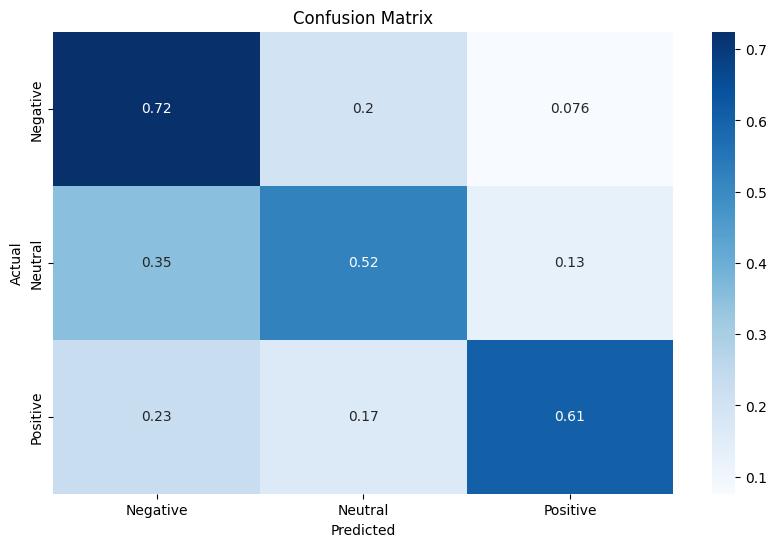

In [29]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_rf,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


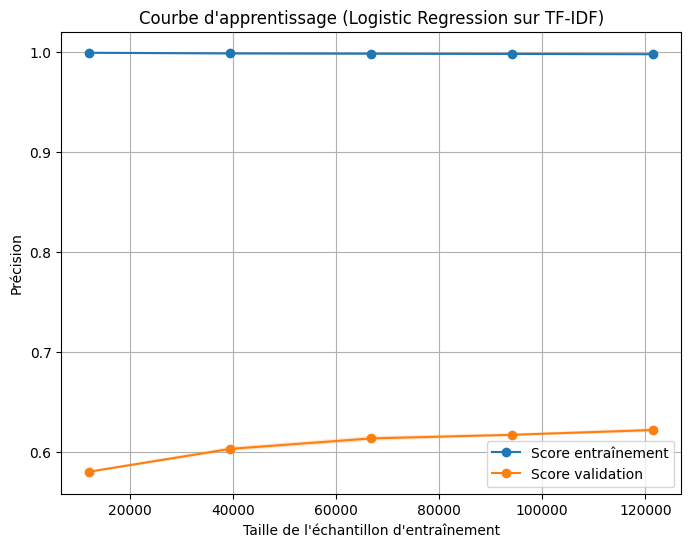

In [ ]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    rf, x, y,
    cv=5,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (Random Forest sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()

# under fitting

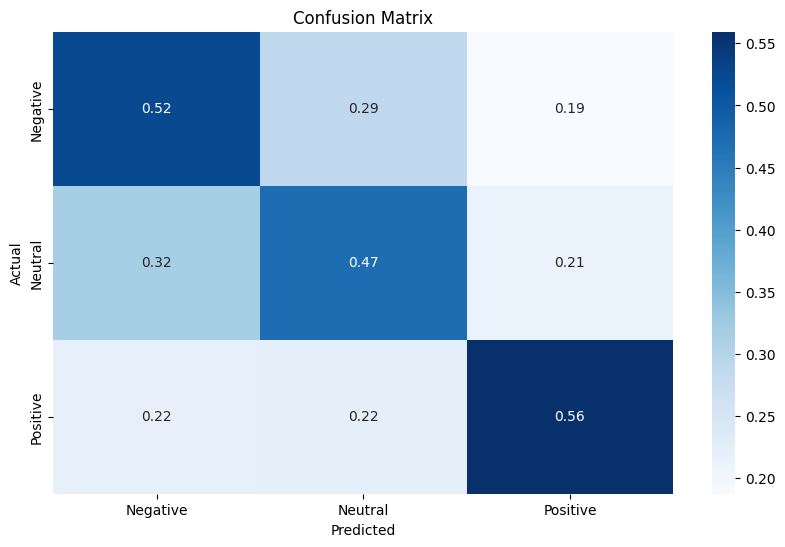

In [30]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_dt,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

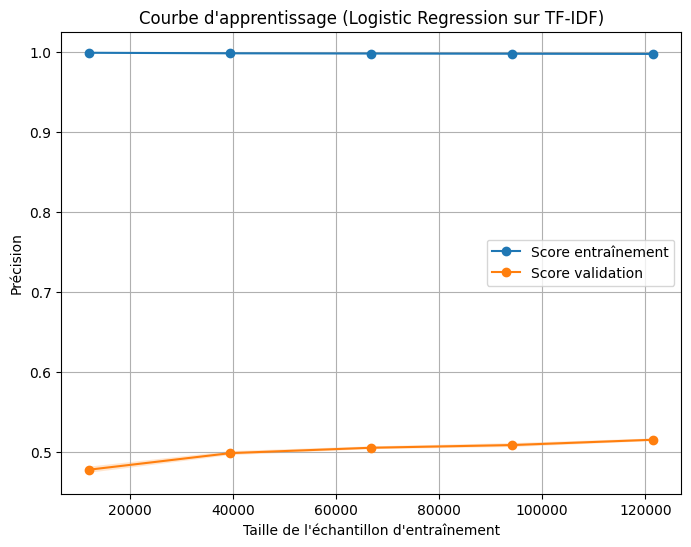

In [34]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    dt, x, y,
    cv=5,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (Decision tree sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()

# under fitting 

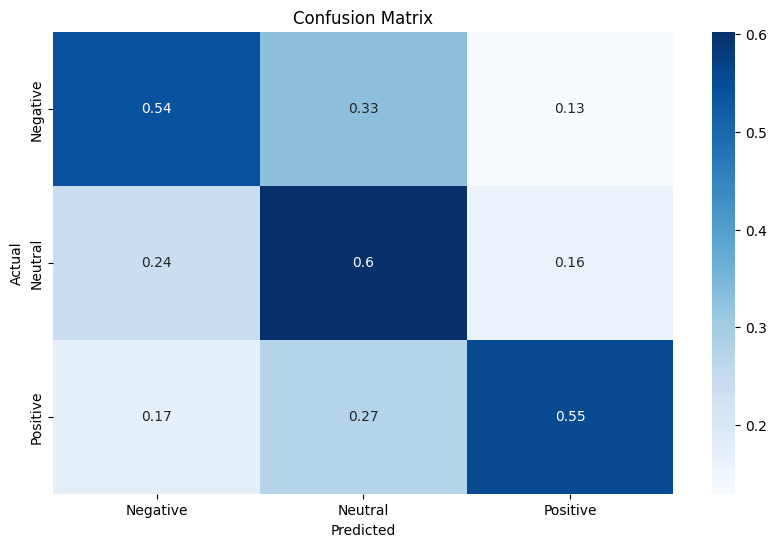

In [19]:
# Matrice de confusion
# import seaborn as sns
# conf_matrix = confusion_matrix(y_test, y_pred_svm,normalize='true' )
# plt.figure(figsize=(10, 6))
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

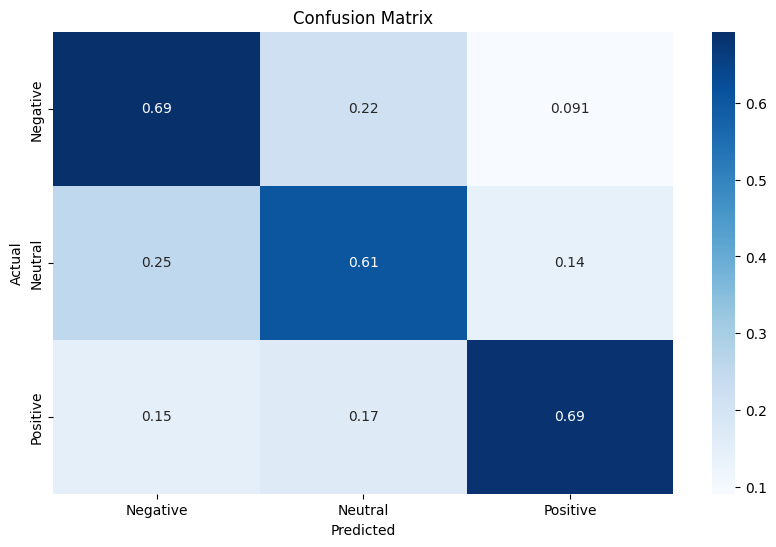

In [31]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_lr,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

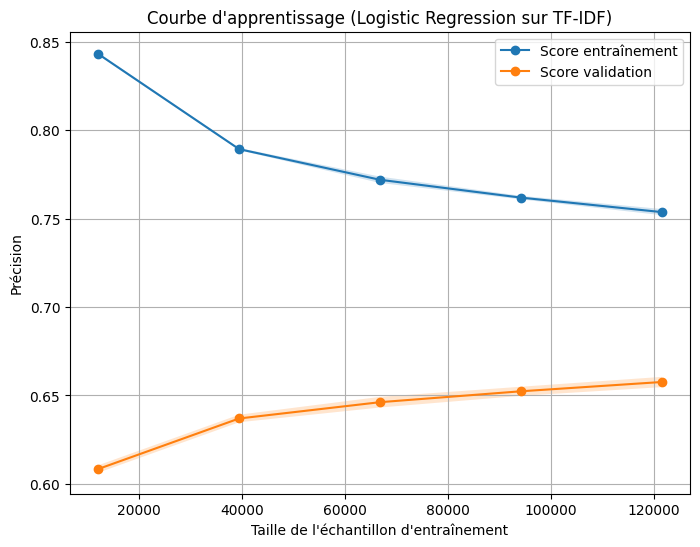

In [36]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    lr, x, y,
    cv=5,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (Logistic Regression sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()

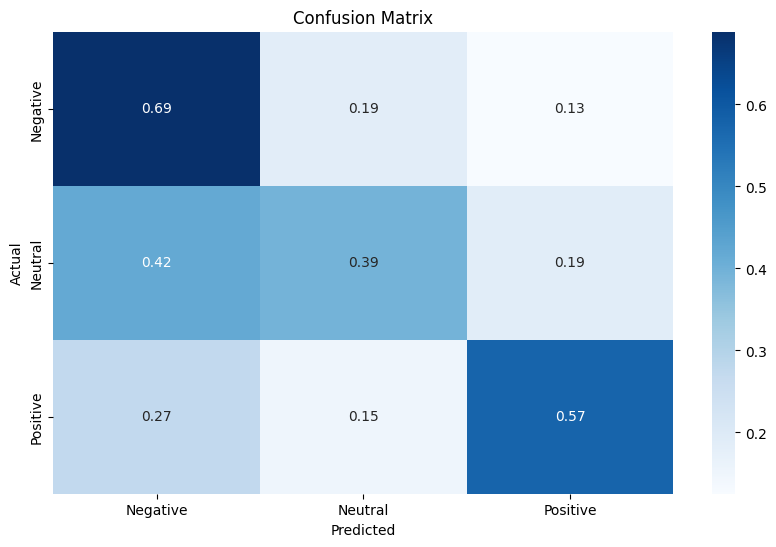

In [32]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_knn,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

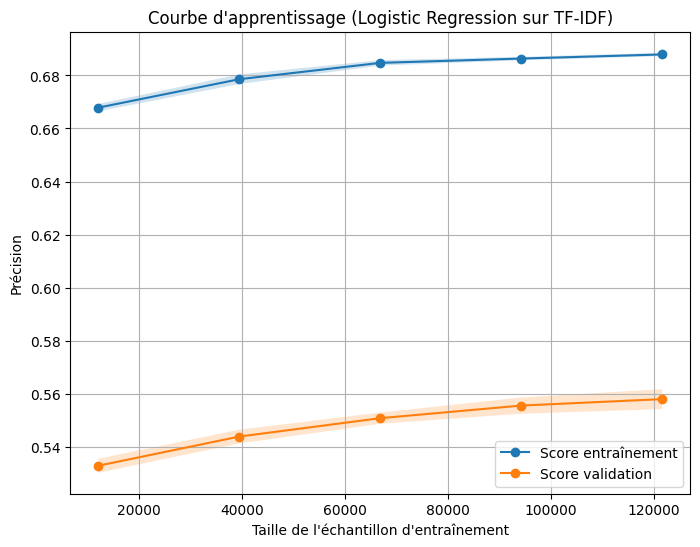

In [37]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    knn, x_knn, y,
    cv=5,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (KNN sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()
# under fitting

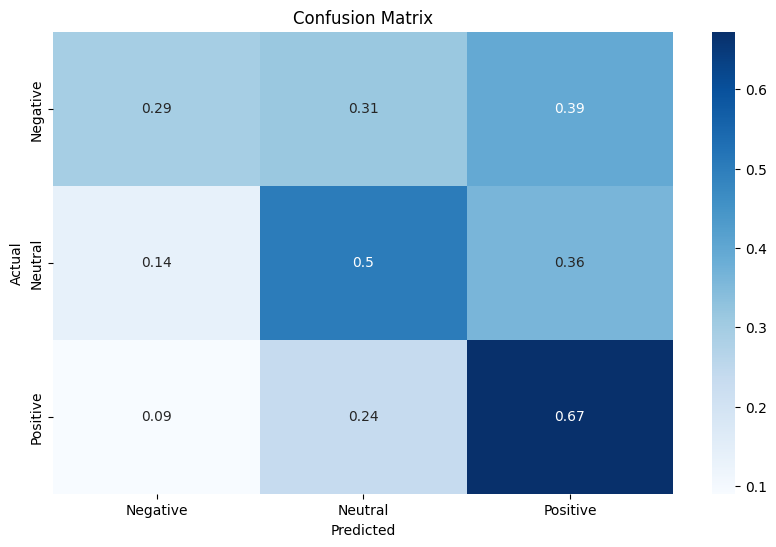

In [22]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_txtb ,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

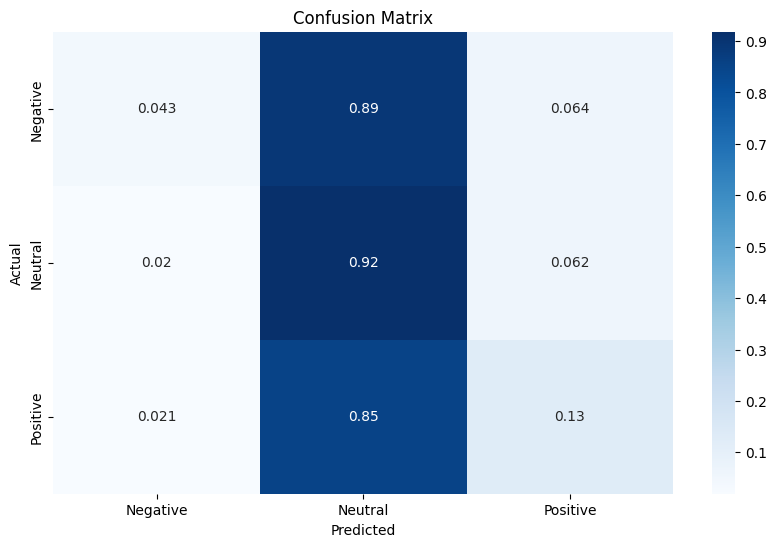

In [23]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_textblob ,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Vader

In [47]:
print(f"les shapes des données d'entraînement et de test: {w_train.shape}, {w_test.shape}")

les shapes des données d'entraînement et de test: (121507,), (30377,)


In [ ]:
# import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer(lexicon_file="/Users/carla/Desktop/GitHub/Projet-RNCP/data/vader_lexicon.txt")
analyzer.translate = False
def getSentiment(phrase):
    s = analyzer.polarity_scores(phrase)
    print(s)
    if s['compound'] <= -0.05:
        sentiment = 0
    elif s['compound'] >= 0.05:
        sentiment = 1
    else:
        sentiment = 2
    return sentiment

predictions_vader = []
for text in w_test:
    sentiment = getSentiment(text)
    # print(sentiment)
    if sentiment == 2:
        predictions_vader.append(2) # positive
    elif sentiment == 0:
        predictions_vader.append(0)
    elif sentiment == 1:
        predictions_vader.append(1)
    else:
        predictions_vader.append(1)

y_pred_vader = np.array(predictions_vader)

print(y_pred_vader)
print("RÉSULTATS vader:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_vader)}")
acc_vader = accuracy_score(y_test, y_pred_vader)
#accuracy.append(acc_vader)
print(f"Accuracy: {acc_vader:.4f}")
fscore_vader = f1_score(y_test, y_pred_vader, average='weighted')
#fscores.append(fscore_vader)
print(f"F1 Score: {fscore_vader:.4f}\n")

{'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'compound': 0.3612}
{'neg': 0.15, 'neu': 0.551, 'pos': 0.299, 'compound': 0.4404}
{'neg': 0.228, 'neu': 0.772, 'pos': 0.0, 'compound': -0.7783}
{'neg': 0.198, 'neu': 0.509, 'pos': 0.293, 'compound': 0.1759}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.125, 'neu': 0.796, 'pos': 0.08, 'compound': -0.3182}
{'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.8625}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.6696}
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.128}
{'neg': 0.049, 'neu': 0.887, 'pos': 0.064, 'compound': 0.1779}
{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.8037}
{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.4019}
{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.6476}
{'neg': 0.098, 'neu': 0.902, 'pos': 0.0, 'compound': -0.4023}
{'neg': 0.142, 'neu': 0.623, 'pos': 0.236, 'compound': 0.3947}
{'neg': 0.0, 'neu': 0.671, '

In [1]:
readSentiment = SentimentIntensityAnalyzer()
# df_train['vader_sentiment'] = df_train['text'].apply(lambda x: readSentiment.polarity_scores(x)['compound'])

NameError: name 'SentimentIntensityAnalyzer' is not defined

In [158]:
def getSentiment(phrase):
    s = readSentiment.polarity_scores(phrase)
    if s['compound'] <= -0.05:
        sentiment = 0
    elif s['compound'] >= 0.05:
        sentiment = 1
    else:
        sentiment = 2
    return sentiment, s

In [162]:
sentiments = ['Negative', 'Positive', 'Neutral']
score=0
for index, row in df_train.iterrows():
    txt = row['text']
    label = row['label']
    pred = readSentiment.polarity_scores(txt)
    sent = sentiments[getSentiment(txt)[0]]
    # print( index,"\n",txt,"\n",label,"\n", pred,"\n",sent,"\n_____________")
    if sent == label:
        score += 1
print("Score: ", score, "/", len(df_sample), "=", score/len(df_sample)*100, "%")

IndexError: list index out of range

In [160]:
sentiments = ['Negative', 'Positive', 'Neutral']
score=0
for index, row in df_fr.iterrows():
    txt = row['text_fr']
    label = row['Sentiment']
    pred = readSentiment.polarity_scores(txt)
    sent = sentiments[getSentiment(txt)[0]]
    # print( index,"\n",txt,"\n",label,"\n", pred,"\n",sent,"\n_____________")
    if sent == label:
        score += 1
print("Score: ", score, "/", len(df_sample), "=", score/len(df_sample)*100, "%")

HTTPError: HTTP Error 500: Internal Server Error

# Text blob

In [22]:

# blob1 = tb(u"Quelle belle matinée")
# print(blob1.sentiment)

# blob2 = tb(u"C'est une voiture terribles.")
# print(blob2.sentiment)

# print(blob1.analyzer is blob2.analyzer)


In [23]:
# text raw
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
for i in df['comment'][:10]:
    print(i)
    print(tb(i).sentiment)
    print(tb(i).sentiment[0])  # Affiche la polarité entre -1 et 1
    print(tb(i).sentiment[1])  # Affiche la subjectivité entre 0 et 1
    vs = tb(i).sentiment[0]
    if (vs > 0):
        print('Positive')
    elif (vs < 0):
        print('Negative')
    else:
        print('Neutral')
    print("\n")

Merci à Odoo le sponsor cette vidéo ! Pour découvrir Odoo, clique juste ici : https://www.odoo.com/r/cAlx

Bonne découverte ou redécouverte à tous ! (et allez écouter Childish, c'est important)

bises 🙏
(0.31, 0.25000000000000006)
0.31
0.25000000000000006
Positive


Fait une vidéo sur Tyler the creator stp
(0.0, 0.0)
0.0
0.0
Neutral


Lol le disclaimer😂
(0.0, 0.0)
0.0
0.0
Neutral


où peut-on voir la série "Earn and Alfred" ???
(0.0, 0.0)
0.0
0.0
Neutral


C'est pas un re upload ? Impression de déjà vu (pas une critique foireuse, juste impression de déjà vu de fou)
(0.06999999999999999, 0.6166666666666667)
0.06999999999999999
0.6166666666666667
Positive


fais une vidéo sur tyler the creator stpppppppp
(0.0, 0.0)
0.0
0.0
Neutral


C est pas SEB c est un robot 😅😅😅
(0.0, 0.0)
0.0
0.0
Neutral


Super vidéo comme d’hab, mais je trouve comme souvent que c’est trop individualiste. Il arrive à tout faire aussi en grande partie parce que à chaque fois il est entouré des bonnes personnes qui so

In [24]:
# # text clean
# tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
# for i in df['comment_clean_lem'][:10]:
#     print(i)
#     print(tb(i).sentiment)
#     print(tb(i).sentiment[0])  # Affiche la polarité entre -1 et 1
#     print(tb(i).sentiment[1])  # Affiche la subjectivité entre 0 et 1
#     vs = tb(i).sentiment[0]
#     if (vs > 0):
#         print('Positive')
#     elif (vs < 0):
#         print('Negative')
#     else:
#         print('Neutral')
#     print("\n")

odoo sponsor decouvrir odoo clique decouverte redecouvrir aller ecouter childish important bise
(0.20000000000000004, 0.18333333333333335)
0.20000000000000004
0.18333333333333335
Positive


video_sur tyler_the_creator
(0.0, 0.0)
0.0
0.0
Neutral


mort_de_rire disclaimer
(0.0, 0.0)
0.0
0.0
Neutral


voir serie earn alfred
(0.0, 0.0)
0.0
0.0
Neutral


reupload impression deja_vu critique foireux impression deja_vu
(0.0, 0.75)
0.0
0.75
Neutral


video_sur tyler_the_creator stp
(0.0, 0.0)
0.0
0.0
Neutral


robot
(0.0, 0.0)
0.0
0.0
Neutral


super habitude trouver trop individualiste arriver grand partie fois entourer personne specialiser domaine
(0.25, 0.6)
0.25
0.6
Positive


coiffure rasage deranger monde contre gresillement sortie fois immersion
(0.0, 0.0)
0.0
0.0
Neutral


super vraiment contre faillir taper tete contre fois prononcer childish
(0.35, 0.7)
0.35
0.7
Positive




In [45]:
# # text clean
# score = 0
# tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
# for index, i in enumerate(df_sample['text_fr']):
#     #print(i)
#     #print(tb(i).sentiment)
#     #print(tb(i).sentiment[0])  # Affiche la polarité entre -1 et 1
#     #print(tb(i).sentiment[1])  # Affiche la subjectivité entre 0 et 1
#     vs = tb(i).sentiment[0]
#     sent = df_sample['Sentiment'].iloc[index]
#     if (vs > 0):
#         #print('Positive')
#         label = 'Positive'
#     elif (vs < 0):
#         #print('Negative')
#         label = 'Negative'
#     else:
#         #print('Neutral')
#         label = 'Neutral'
#     if label == sent:
#         score += 1
#     #print("\n______________________________________________")
# print("Score: ", score, "/", 1000, "=", score/1000*100, "%")

Score:  471 / 1000 = 47.099999999999994 %


# Emotion English DistilRoBERTa-base

In [32]:
from transformers import pipeline
classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base", 
    return_all_scores=True,
    max_length=531)

/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
def get_sentiment(text : str, classifier, all=False ) -> str:
    res = classifier(text)[0]
    max_result = max(res, key=lambda x: x['score'])
    if all == True :
        return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
    else:
        return max_result['label']

for i in df_fr['text_fr'][:10]:
    print(i)
    print(get_sentiment(i, classifier=classifier))
    print("\n")

NameError: name 'df_fr' is not defined

In [33]:
for i in df['comment_clean_lem'][:10]:
    print(i)
    print(get_sentiment(i, classifier=classifier))
    print("\n")


odoo sponsor decouvrir odoo clique decouverte redecouvrir aller ecouter childish important bise
neutral


video_sur tyler_the_creator
joy


mort_de_rire disclaimer
neutral


voir serie earn alfred
neutral


reupload impression deja_vu critique foireux impression deja_vu
neutral


video_sur tyler_the_creator stp
joy


robot
neutral


super habitude trouver trop individualiste arriver grand partie fois entourer personne specialiser domaine
neutral


coiffure rasage deranger monde contre gresillement sortie fois immersion
neutral


super vraiment contre faillir taper tete contre fois prononcer childish
anger




In [42]:
for index, i in enumerate(df_sample['text_fr']):
    print(i)
    print(get_sentiment(i, classifier=classifier))
    print("\n")


Cette vidéo était assez difficile à suivre et à comprendre.
disgust


Aimez votre spectacle et appréciez votre plateforme courageuse. Nous vous remercions.
fear


quel thème de couleur utilisez-vous S'il vous plaît me dire
fear


Celui qui s'inquiète de tout ce qu'ils ont fait... Mais !!! Si quelqu'un d'autre fait la même chose... alors et alors seulement c'est maintenant un crime !!! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

RuntimeError: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]

# distilbert-base-multilingual-cased-sentiments-student

In [ ]:
from transformers import pipeline
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True, max_length=512, 
)
def get_sentiment(text : str, classifier, all=False ) -> str:
    res = classifier(text)[0]
    max_result = max(res, key=lambda x: x['score'])
    if all == True :
        return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
    else:
        return max_result['label']


/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [9]:
for i in range(len(df_yt[:10])):
    text = df_yt['text_fr'].iloc[i]
    label = df_yt['Sentiment'].iloc[i]
    sentiment = get_sentiment(text, classifier=distilled_student_sentiment_classifier)
    print(text)
    print(sentiment)
    print(label)
    print("\n___________________________")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Quelqu'un sait quel film c'est ?
negative
Neutral

___________________________
Le fait qu'ils se retiennent tout en étant aussi agressifs .
negative
Positive

___________________________
Vous attendez la prochaine vidéo ?
negative
Neutral

___________________________
Merci pour la grande vidéo. Je ne comprends pas pourquoi la DB continue d'être accessible par le port 8080 lorsque la machine locale se connecte au conteneur docker par le port 5432? Ou, pourquoi n'est-il pas possible de faire des requêtes GET au port 5432 sur ma machine locale? Est-ce juste parce que le port 5432 est seulement le port utilisé pour connecter l'application à la base de données, mais l'application elle-même est toujours en charge HTTP à travers 8080?
positive
Neutral

___________________________
C'est comme ça qu'on est en Amérique, à l'exception de New York et DC.
negative
Positive

___________________________
Dei løk de seim
negative
Neutral

___________________________
Numéro deux parce qu'il semble le me

In [48]:
for i in df['comment_clean_lem'][:10]:
    print(i)
    print(get_sentiment(i, classifier=distilled_student_sentiment_classifier))
    print("\n")


odoo sponsor decouvrir odoo clique decouverte redecouvrir aller ecouter childish important bise
negative


video_sur tyler_the_creator
positive


mort_de_rire disclaimer
negative


voir serie earn alfred
positive


reupload impression deja_vu critique foireux impression deja_vu
negative


video_sur tyler_the_creator stp
positive


robot
positive


super habitude trouver trop individualiste arriver grand partie fois entourer personne specialiser domaine
positive


coiffure rasage deranger monde contre gresillement sortie fois immersion
negative


super vraiment contre faillir taper tete contre fois prononcer childish
negative




In [52]:
score = 0
for index, i in enumerate(df_sample['text_fr'][:10]):
    #print(i)
    sent = get_sentiment(i, classifier=distilled_student_sentiment_classifier)
    label = df_sample['Sentiment'].iloc[index]
    #print(sent)
    #print("\n")
    if sent == label:
        score += 1
print("Score: ", score, "/", 10, "=", score/10*100, "%")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Score:  0 / 10 = 0.0 %


In [31]:
def get_polarity(text, classifier):
    vs = classifier(text).sentiment[0]
    if (vs > 0):
        return('Positive')
    elif (vs < 0):
        return('Negative')
    else:
        return('Neutral')

In [32]:
df["sentiment_label"] = df["comment"].astype(str).apply(
    lambda x: get_polarity(x, tb) # Polarité
)
df.head()

,channelId,videoId,author,publishedAt,comment,extractedAt,tokens_clean_lem,comment_clean_lem,sentiment_label
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10,"['odoo', 'sponsor', 'decouvrir', 'odoo', 'cliq...",odoo sponsor decouvrir odoo clique decouverte ...,Positive
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10,"['video_sur', 'tyler_the_creator']",video_sur tyler_the_creator,Neutral
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10,"['mort_de_rire', 'disclaimer']",mort_de_rire disclaimer,Neutral
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10,"['voir', 'serie', 'earn', 'alfred']",voir serie earn alfred,Neutral
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10,"['reupload', 'impression', 'deja_vu', 'critiqu...",reupload impression deja_vu critique foireux i...,Positive


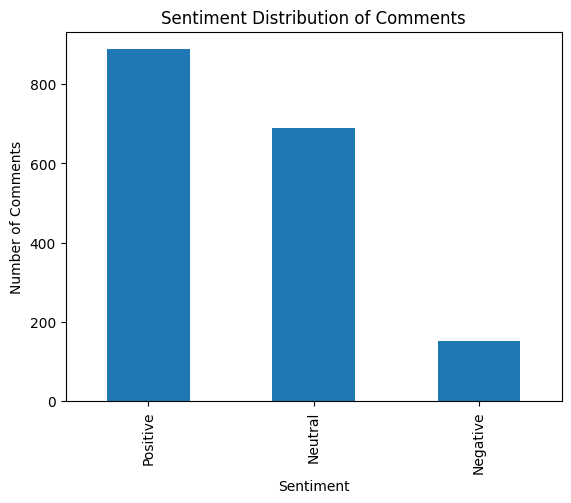

In [33]:
# distribution des commentaires en fonction des sentiments
df["sentiment_label"].value_counts().plot(kind='bar', title='Sentiment Distribution')
import matplotlib.pyplot as plt
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution of Comments')
plt.show()

# ALLOCINE MODEL

In [2]:
from transformers import pipeline

# Use PyTorch instead of TensorFlow
# classifier = pipeline(
#     "text-classification",
#     model="camembert-base",
#     framework="pt"  # Explicitly specify PyTorch
# )

classifier = pipeline(
    "sentiment-analysis",
    model="tblard/tf-allocine",
    framework="pt"
)


ImportError: 
TFCamembertForSequenceClassification requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


In [116]:
! pip install tensorflow
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine",from_tf=True)

nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached h5py-3.14.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 7.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ImportError: 
TFAutoModelForSequenceClassification requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


In [11]:
# CamemBERT pour le français
from transformers import pipeline

# classifier = pipeline(
#     "sentiment-analysis",
#     model="tblard/tf-allocine",  # Spécialisé français
#     tokenizer="tblard/tf-allocine"
# )

# Ou pour multilingue
classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


# Ecriture du fichier

In [34]:
df.to_csv('database_sentiment_label.csv', index=False)

In [1]:
from transformers import pipeline

classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
)

/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


In [7]:
import pickle
path = "../ressources/sentimentnmodel.pkl"
import os 
os.makedirs("../ressources", exist_ok=True)
with open(path, "wb") as mdl:
    pickle.dump(classifier, mdl)

In [7]:
df_yt['label']= df_yt['text_fr'].apply(lambda x: classifier(x)[0].get('label'))

df_yt

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr,label
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1,Quelqu'un sait quel film c'est ?,neutral
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17,Le fait qu'ils se retiennent tout en étant aus...,negative
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27,Vous attendez la prochaine vidéo ?,neutral
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27,Merci pour la grande vidéo. Je ne comprends pa...,negative
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2,"C'est comme ça qu'on est en Amérique, à l'exce...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,UgyhNXeIJU52Tq5k6EV4AaABAg,IEf1KAcK6A8,ES6 JavaScript Tutorial for Beginners - Gettin...,@VishalDeepVerma1,UCdMKjjzlm68fwnLhbCROddw,"The best tutorial !! Do't go anywhere, you can...",Positive,0,1,2017-09-11 05:16:30,DE,27,"Le meilleur tutoriel !! Ne partez pas, vous ne...",positive
24996,Ugwg_ThYp_qokkNGSiN4AaABAg_aug,MModz5jafy0,Bigger isn’t always better!,AugmentedUser,AugmentedCID,"Yeah, but the big hammer looks like it has a g...",Negative,0,0,2025-02-04 01:28:18,GB,26,"Oui, mais le gros marteau a l'air d'avoir un i...",neutral
24997,UgxTW8JBkQ-DoEfJpnl4AaABAg,RABj7jsRVCM,Update from Ukraine | Wow! Ukraine moves in! ...,@bill7243,UCD3QddGQrFDpqRCvBvKswIg,"Many thanks Dennis, keep up the hope and your ...",Positive,19,0,2025-01-12 08:51:04,AU,25,"Merci Dennis, gardez l'espoir et votre grand h...",positive
24998,UgwMGbs4K6EF4VlZAfV4AaABAg,2jWyuONvW1k,BREAKING NEWS: TOMMY ROBINSON SPEAKS FROM PRIS...,@donnaweetch7589,UCDRNvvjd7gtdSEUz9ESXVlA,"This is disgusting, where are the human rights...",Negative,1,0,2025-01-10 16:52:58,GB,25,"C'est dégoûtant, où sont les gens des droits h...",negative


In [16]:
predictions_roberta = []
for text in w_test:
    res = classifier(text)[0]
    sentiment =res.get('label')
    if sentiment == "positif":
        predictions_roberta.append(2) # positive
    elif sentiment == "negatif":
        predictions_roberta.append(0)
    elif sentiment == "neutral":
        predictions_roberta.append(1)
    else:
        predictions_roberta.append(1)

y_pred_roberta = np.array(predictions_roberta)

print(y_pred_roberta)
print("RÉSULTATS roberta:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_roberta)}")
acc_roberta = accuracy_score(y_test, y_pred_roberta)
print(f"Accuracy: {acc_roberta:.4f}")
fscore_roberta = f1_score(y_test, y_pred_roberta, average='weighted')
print(f"F1 Score: {fscore_roberta:.4f}\n")

[1 1 1 ... 1 1 1]
RÉSULTATS roberta:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1707
           1       0.34      1.00      0.50      1684
           2       0.00      0.00      0.00      1609

    accuracy                           0.34      5000
   macro avg       0.11      0.33      0.17      5000
weighted avg       0.11      0.34      0.17      5000

Accuracy: 0.3368
F1 Score: 0.1697



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [18]:
for i, text in enumerate(df_yt['text_fr'][:100]):
    print(text)
    res = classifier(text)[0]
    sentiment =res.get('label')
    label = df_yt['Sentiment'].iloc[i]
    print(label)
    print(sentiment)
    print("____________________________")

Quelqu'un sait quel film c'est ?
Neutral
neutral
____________________________
Le fait qu'ils se retiennent tout en étant aussi agressifs .
Positive
negative
____________________________
Vous attendez la prochaine vidéo ?
Neutral
neutral
____________________________
Merci pour la grande vidéo. Je ne comprends pas pourquoi la DB continue d'être accessible par le port 8080 lorsque la machine locale se connecte au conteneur docker par le port 5432? Ou, pourquoi n'est-il pas possible de faire des requêtes GET au port 5432 sur ma machine locale? Est-ce juste parce que le port 5432 est seulement le port utilisé pour connecter l'application à la base de données, mais l'application elle-même est toujours en charge HTTP à travers 8080?
Neutral
negative
____________________________
C'est comme ça qu'on est en Amérique, à l'exception de New York et DC.
Positive
negative
____________________________
Dei løk de seim
Neutral
neutral
____________________________
Numéro deux parce qu'il semble le meill

In [15]:
commentaire = "Cette vidéo est géniale, j'ai adoré !"
resultat = classifier(commentaire)
print(resultat[0].get('label'))

positive


# entrainement des modèle classiques sur le résultat du transformer

In [ ]:
# connexion à la base de données 

# récuprération des données

#